<a href="https://colab.research.google.com/github/kuds/rl-atari-tennis/blob/main/%5BAtari%20Tennis%5D%20Single-Agent%20Reinforcement%20Learning%20PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Atari Tennis] Single-Agent Reinforcement Learning

In [1]:
!pip install swig

In [2]:
!pip install gymnasium gymnasium[atari] autorom

In [3]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [4]:
!pip install stable-baselines3

In [5]:
import platform
import torch
import numpy
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.vec_env import VecTransposeImage
import matplotlib.pyplot
import matplotlib
import os
import gymnasium
from importlib.metadata import version
from datetime import datetime
import csv
import time
import google.colab.drive

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [6]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")

Python Version: 3.10.12
Torch Version: 2.4.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Gymnasium Version: 0.29.1
Numpy Version: 1.26.4
Stable Baselines3 Version: 2.3.2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
gdrive_path = "/content/gdrive"
google.colab.drive.mount(gdrive_path, force_remount=True)

Mounted at /content/gdrive


In [8]:
rl_type = "PPO"
env_str = "ALE/Tennis-v5"
trained_model = "final_atari_tennis_ppo"
log_dir = "{}/MyDrive/Finding Theta/logs/{}/{}".format(gdrive_path,
                                                       env_str,
                                                       rl_type)
training_data_path = os.path.join(log_dir, "training jobs")
time_folder = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
model_folder_path = os.path.join(log_dir, "training jobs", time_folder)

#Create Folders
os.makedirs(log_dir, exist_ok=True)
os.makedirs(training_data_path, exist_ok=True)
os.makedirs(model_folder_path, exist_ok=True)

In [9]:
# https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
# https://stable-baselines3.readthedocs.io/en/master/common/atari_wrappers.html
env = make_atari_env(env_str, n_envs=1, seed=0)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (84, 84, 1)
Actions Space:  Discrete(18)


In [10]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (210, 160, 3)
Actions Space:  Discrete(18)


In [ ]:
# Create the Training Atari Tennis environment with appropriate wrappers
env = make_atari_env(env_str, n_envs=16, seed=0)
env = VecTransposeImage(env)
env = VecFrameStack(env, n_stack=4)

# Create the Evaluation Atari Tennis environment with appropriate wrappers
# Disable Frame Skip
env_val_wrap_args = {"frame_skip": 0, "noop_max": 30}
env_val = make_atari_env(
    env_str,
    n_envs=1,
    seed=1,
    wrapper_kwargs=env_val_wrap_args)
env_val = VecTransposeImage(env_val)
env_val = VecFrameStack(env_val, n_stack=4)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(
    env_val,
    best_model_save_path=model_folder_path,
    log_path=model_folder_path,
    eval_freq=5_000,
    render=False,
    deterministic=True,
    n_eval_episodes=5)

# Create Checkpoint Callback
checkpoint_callback = CheckpointCallback(
    save_freq=5_000,
    save_path=os.path.join(model_folder_path, "checkpoints"),
    name_prefix="atari_tennis_ppo",
    save_replay_buffer=True,
    save_vecnormalize=True,
)

# Create the callback list
callbackList = CallbackList([checkpoint_callback, eval_callback])

# Initialize PPO
# ent_coef - encourages exploration of other actins
model = PPO("CnnPolicy",
            env,
            verbose=0,
            batch_size=128,
            ent_coef=0.1,
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

# Train the model
model.learn(total_timesteps=8_000_000,
            progress_bar=True,
            callback=callbackList)

# Save the trained model
model.save(os.path.join(model_folder_path, trained_model))

env.close()
env_val.close()

  51% ━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 4,079,984/8,000,000  [ 10:38:12 < 8:45:02 , 124 it/s ]

In [18]:
# Get model path from last training job (uncomment if training job interrupted)
# List all entries in the directory
entries = os.listdir(training_data_path)

# Filter out only directories
folders = [entry for entry in entries if os.path.isdir(os.path.join(training_data_path, entry))]

# Sort the folders alphabetically
folders.sort()

# Get the last folder
model_folder_path = os.path.join(training_data_path, folders[-1])
print(model_folder_path)

/content/gdrive/MyDrive/Finding Theta/logs/ALE/Tennis-v5/PPO/training jobs/2024-09-26 03:49:44


In [19]:
# Create the Evaluation Atari Tennis environment with appropriate wrappers
# Disable Frame Skip
env_val_wrap_args = {"frame_skip": 0, "noop_max": 30}
env_val = make_atari_env(env_str,
                         n_envs=1,
                         seed=1,
                         wrapper_kwargs=env_val_wrap_args)
env_val = VecTransposeImage(env_val)
env_val = VecFrameStack(env_val, n_stack=4)

# Load the best model
best_model_path = os.path.join(model_folder_path, "best_model")
best_model = PPO.load(best_model_path, env=env_val)

mean_reward, std_reward = evaluate_policy(
    best_model,
    env_val,
    n_eval_episodes=5)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

best_metrics_path = os.path.join(log_dir, "best_model_metrics.csv")

# Create Best Model Metrics file if not there
if(not os.path.isfile(best_metrics_path)):
  with open(best_metrics_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["batch_size",
                     "ent_coef",
                     "learning_rate",
                     "num_timesteps",
                     "mean_reward",
                     "std_reward",
                     "n_steps",
                     "n_envs",
                     "gamma",
                     "gae_lambda",
                     "clip_range_vf",
                     "n_epochs"])

new_data = [best_model.batch_size,
            best_model.ent_coef,
            best_model.learning_rate,
            best_model.num_timesteps,
            mean_reward,
            std_reward,
            best_model.n_steps,
            best_model.n_envs,
            best_model.gamma,
            best_model.gae_lambda,
            best_model.n_epochs]

with open(best_metrics_path, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(new_data)

# Record video of the best model playing Atari's Tennis
rec_val = VecVideoRecorder(env_val,
                           os.path.join(model_folder_path, "videos"),
                           video_length=5000,
                           record_video_trigger=lambda x: x == 0,
                           name_prefix="best_model_atari_tennis_ppo")

obs = rec_val.reset()
for _ in range(5000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = rec_val.step(action)
    rec_val.render()
    if dones:
      break

env_val.close()
rec_val.close()

Best Model - Mean reward: -1.00 +/- 0.00


/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/ALE/Tennis-v5/PPO/training jobs/2024-09-26 03:49:44/videos/best_model_atari_tennis_ppo-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/ALE/Tennis-v5/PPO/training jobs/2024-09-26 03:49:44/videos/best_model_atari_tennis_ppo-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/ALE/Tennis-v5/PPO/training jobs/2024-09-26 03:49:44/videos/best_model_atari_tennis_ppo-step-0-to-step-5000.mp4


In [29]:
# Create the Evaluation Atari Tennis environment with appropriate wrappers
# Disable Frame Skip
env_val_wrap_args = {"frame_skip": 0, "noop_max": 30}
env_val = make_atari_env(env_str,
                         n_envs=1,
                         seed=1,
                         wrapper_kwargs=env_val_wrap_args)
env_val = VecTransposeImage(env_val)
env_val = VecFrameStack(env_val, n_stack=4)

final_model_path = os.path.join(model_folder_path, trained_model)

if(not os.path.isfile(final_model_path)):
  # Load last checkpoint model
  print("Loading last checkpoint model")

  checkpoint_path = os.path.join(model_folder_path, "checkpoints")
  entries = os.listdir(checkpoint_path)

  # Filter out only directories
  folders = [entry for entry in entries if os.path.isfile(os.path.join(checkpoint_path, entry))]

  # Get the last folder
  final_model_path = os.path.join(checkpoint_path, folders[-1])
  print(final_model_path)
else:
  # Load final model
  print("Loading final model")


final_model = PPO.load(final_model_path, env=env_val)

# Record video of the final model playing Atari's Tennis
rec_val = VecVideoRecorder(env_val,
                           os.path.join(model_folder_path, "videos"),
                           video_length=5000,
                           record_video_trigger=lambda x: x == 0,
                           name_prefix="final_model_atari_tennis_ppo")

obs = rec_val.reset()
for _ in range(5000):
    action, _states = final_model.predict(obs)
    obs, rewards, dones, info = rec_val.step(action)
    rec_val.render()
    if dones:
      break

env_val.close()
rec_val.close()

Loading last checkpoint model
/content/gdrive/MyDrive/Finding Theta/logs/ALE/Tennis-v5/PPO/training jobs/2024-09-26 03:49:44/checkpoints/atari_tennis_ppo_4160000_steps.zip
Moviepy - Building video /content/gdrive/MyDrive/Finding Theta/logs/ALE/Tennis-v5/PPO/training jobs/2024-09-26 03:49:44/videos/final_model_atari_tennis_ppo-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/gdrive/MyDrive/Finding Theta/logs/ALE/Tennis-v5/PPO/training jobs/2024-09-26 03:49:44/videos/final_model_atari_tennis_ppo-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/gdrive/MyDrive/Finding Theta/logs/ALE/Tennis-v5/PPO/training jobs/2024-09-26 03:49:44/videos/final_model_atari_tennis_ppo-step-0-to-step-5000.mp4


In [20]:
# Print Model
print(best_model.policy)

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
    (cnn): 

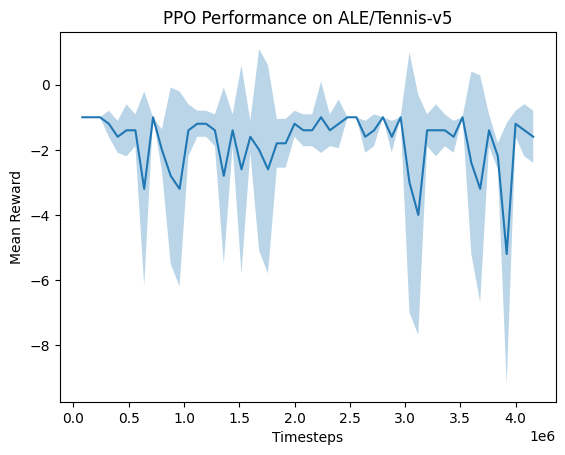

In [21]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(model_folder_path, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()